In [16]:
import os
import pandas as pd
import numpy as np
from pipeline import ClusterFeatures,LBP_3D

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report,roc_auc_score



In [17]:

def XGBoost(X_tr, Y_tr, X_te, Y_te,quick=False):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
    }

    # Create the model
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        tree_method='hist',
        random_state=42
    )

    if quick:
            best_model = xgb_model
            best_model.fit(X_tr, Y_tr)

            xgb_pred = best_model.predict(X_te)


            ConfusionMatrixDisplay.from_estimator(estimator=best_model, X=X_te, y=Y_te)

            print("Classification Report: XGBoost",roc_auc_score(Y_te,xgb_pred))
            report = classification_report(Y_te, xgb_pred, digits=2)
            print(report)
            return best_model


    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='accuracy',  
        cv=10,  
        verbose=1,
        n_jobs=-1  
    )

  
    grid_search.fit(X_tr, Y_tr)

   
    best_model = grid_search.best_estimator_
    best_model.fit(X_tr, Y_tr)

    xgb_pred = best_model.predict(X_te)

    ConfusionMatrixDisplay.from_estimator(estimator=best_model, X=X_te, y=Y_te)

    print("Classification Report: XGBoost",roc_auc_score(Y_te,xgb_pred))
    report = classification_report(Y_te, xgb_pred, digits=2)
    print(report)
    return best_model
def RF(X_tr, Y_tr, X_te, Y_te):

    param_grid = {
        'n_estimators': [int(x) for x in np.linspace(start=10, stop=100, num=10)],  
        'max_depth': range(1, 20),  
        'criterion': ['gini', 'entropy'] 
    }


    optimal_params = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        cv=10, 
        scoring='accuracy',
        verbose=0,
        n_jobs=-1
    )


    optimal_params.fit(X_tr, Y_tr)
    print("Best parameters found: ", optimal_params.best_params_)


    criterion = optimal_params.best_params_['criterion']
    max_depth = optimal_params.best_params_['max_depth']
    n_estimators = optimal_params.best_params_['n_estimators']


    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        criterion=criterion,
        random_state=42
    )

    rf_model.fit(X_tr, Y_tr)


    rf_pred = rf_model.predict(X_te)


    ConfusionMatrixDisplay.from_estimator(estimator=rf_model, X=X_te, y=Y_te)

    print("Best Cross-Validation Score:",optimal_params.best_score_)
    print("Classification Report: Random Forest")
    print(classification_report(Y_te, rf_pred, digits=2),roc_auc_score(Y_te,rf_pred))
    return rf_model


In [18]:

csv_dir = '../Datasets/ETI Study/CSV/Control'
csv_files = [file for file in os.listdir(csv_dir) if file.endswith('.csv')]


dataframes = []
for file in csv_files:
    file_path = os.path.join(csv_dir, file)
    dataframes.append([pd.read_csv(file_path),file_path])

data=[]
for d,p in dataframes:
    name=p.split('_XV')[0]+'_XV'
    name=name.split('/')[-1]
    d.columns=['SV','X','Y','Z']
    if 'WT' in p:
        
        data.append([d,0])
    else:
        data.append([d,1])


lbp=LBP_3D(data)
features=lbp.extract()

In [19]:
features

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,Label
0,0.012716,0.015138,0.007872,0.002422,0.009385,0.026340,0.011807,0.002119,0.014229,0.020285,...,0.005450,0.004239,0.020587,0.013624,0.008477,0.001817,0.009083,0.006661,0.009385,1
1,0.012853,0.013221,0.015424,0.004774,0.012853,0.015791,0.020198,0.007712,0.011017,0.024972,...,0.004774,0.004407,0.020933,0.022769,0.010283,0.001102,0.013588,0.008447,0.010650,0
2,0.013923,0.020475,0.007781,0.002457,0.011057,0.015152,0.012285,0.002867,0.007371,0.022932,...,0.003686,0.002457,0.030713,0.006962,0.008190,0.000819,0.022523,0.004914,0.004095,0
3,0.014065,0.020583,0.010635,0.001372,0.012350,0.023671,0.016810,0.005146,0.009949,0.026758,...,0.005832,0.003774,0.026415,0.011321,0.009605,0.002058,0.018868,0.005832,0.011321,0
4,0.012628,0.022184,0.010239,0.003413,0.013993,0.021160,0.015017,0.004778,0.011945,0.021843,...,0.004096,0.006143,0.018430,0.014676,0.012969,0.003072,0.012287,0.008874,0.012628,0
5,0.011216,0.015702,0.008973,0.001346,0.015253,0.029161,0.025572,0.008075,0.008075,0.013459,...,0.004038,0.002692,0.024226,0.006729,0.005832,0.000449,0.013010,0.004935,0.009421,1
6,0.012277,0.018708,0.011400,0.001754,0.011108,0.020462,0.016077,0.004677,0.016077,0.020170,...,0.004092,0.004092,0.018416,0.019293,0.008769,0.001754,0.014616,0.008477,0.014031,0
7,0.011610,0.016479,0.007865,0.002996,0.012734,0.033708,0.022846,0.006742,0.010112,0.028839,...,0.005993,0.003371,0.026217,0.014232,0.007865,0.001873,0.013109,0.007116,0.010861,1
8,0.010188,0.019358,0.007132,0.005094,0.011207,0.027509,0.009170,0.003566,0.009679,0.026490,...,0.003566,0.002038,0.024962,0.012736,0.006623,0.001528,0.016302,0.006623,0.007132,0
9,0.014631,0.018812,0.008659,0.002986,0.012541,0.032248,0.016721,0.005673,0.013138,0.018214,...,0.003882,0.005375,0.025381,0.016423,0.008958,0.001493,0.011645,0.006271,0.008958,1


In [20]:
labels=features['Label']
features=features.drop(columns=['Label'])
features=features.apply(pd.to_numeric, errors='coerce')

features.fillna(0,inplace=True)


Classification Report: XGBoost 0.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       2.0
           1       0.00      0.00      0.00       1.0

    accuracy                           0.00       3.0
   macro avg       0.00      0.00      0.00       3.0
weighted avg       0.00      0.00      0.00       3.0



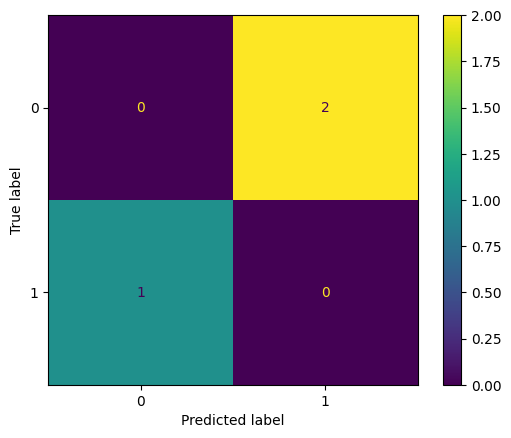

In [21]:

X_train, X_test, y_train, y_test = train_test_split(features.values, labels, test_size=0.2, random_state=42,stratify=labels)

modelLBP=XGBoost(X_train,y_train,X_test,y_test,True)

In [22]:

csv_dir = '../Datasets/ETI Study/CSV/Trikafta'
csv_files = [file for file in os.listdir(csv_dir) if file.endswith('.csv')]


dataframes = []
for file in csv_files:
    file_path = os.path.join(csv_dir, file)
    dataframes.append([pd.read_csv(file_path),file_path])

data=[]
for d,p in dataframes:
    name=p.split('_XV')[0]+'_XV'
    name=name.split('/')[-1]
    d.columns=['SV','X','Y','Z']
    if 'CF' in p:
        
        data.append([d,0])
    else:
        data.append([d,1])



lbp=LBP_3D(data)
features=lbp.extract()

In [23]:
labels=features['Label']
features=features.drop(columns=['Label'])
features=features.apply(pd.to_numeric, errors='coerce')

features.fillna(0,inplace=True)


In [24]:
modelLBP.predict(features)

array([0, 1, 1, 1, 0, 0, 0, 0, 0])

In [32]:

csv_dir = '../Datasets/ETI Study/CSV/Control'
csv_files = [file for file in os.listdir(csv_dir) if file.endswith('.csv')]


dataframes = []
for file in csv_files:
    file_path = os.path.join(csv_dir, file)
    dataframes.append([pd.read_csv(file_path),file_path])

data=[]
for d,p in dataframes:
    name=p.split('_XV')[0]+'_XV'
    name=name.split('/')[-1]
    d.columns=['Specific Ventilation (mL/mL)','x (mm)','y (mm)','z (mm)']
    if 'WT' in p:
        
        data.append([d,0])
    else:
        data.append([d,1])



c=ClusterFeatures(data)
features=c.extract()

/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but K

In [33]:
labels=features['Label']
features=features.drop(columns=['Label'])
features=features.apply(pd.to_numeric, errors='coerce')

features.fillna(0,inplace=True)



Classification Report: XGBoost 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



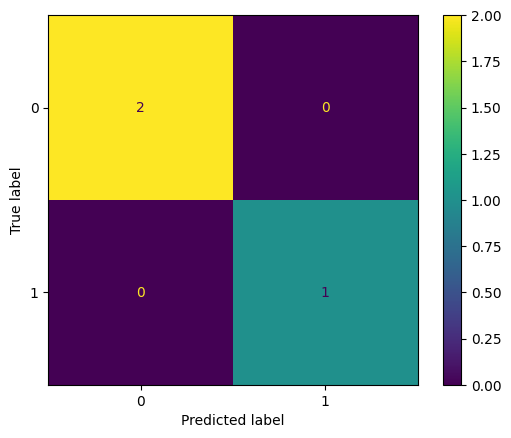

In [34]:
X_train, X_test, y_train, y_test = train_test_split(features.values, labels, test_size=0.2, random_state=42,stratify=labels)

model=XGBoost(X_train,y_train,X_test,y_test,True)

In [42]:

csv_dir = '../Datasets/ETI Study/CSV/Trikafta'
csv_files = [file for file in os.listdir(csv_dir) if file.endswith('.csv')]


dataframes = []
for file in csv_files:
    file_path = os.path.join(csv_dir, file)
    dataframes.append([pd.read_csv(file_path),file_path])

data=[]
for d,p in dataframes:
    name=p.split('_XV')[0]+'_XV'
    name=name.split('/')[-1]
    d.columns=['Specific Ventilation (mL/mL)','x (mm)','y (mm)','z (mm)']
    if 'CF' in p:
        
        data.append([d,0])
    else:
        data.append([d,1])



c=ClusterFeatures(data)
features=c.extract()


/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but K

In [43]:
labels=features['Label']
features=features.drop(columns=['Label'])
features=features.apply(pd.to_numeric, errors='coerce')

features.fillna(0,inplace=True)

In [44]:
model.predict(features)

array([0, 0, 1, 0, 0, 1, 0, 0, 0])